# Delphi Test Notebook

This notebook contains a simple Delphi workflow designed to test the spectrum of Delphi's capabilities and it's integration with INDRA statements.

## Construct and visualize CAG corresponding to use case

In [1]:
%load_ext autoreload
%autoreload 2
from delphi.utils import get_data_from_url
import urllib.request as request
import pickle
from delphi.AnalysisGraph import AnalysisGraph
from delphi.visualization import visualize
from delphi.manipulation import merge_nodes
from delphi.assembly import get_valid_statements_for_modeling
from delphi.subgraphs import get_subgraph_for_concept_pairs
import pandas as pd
from delphi.inspection import statements
import delphi.jupyter_tools as jt
from delphi.quantification import map_concepts_to_indicators

/root/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
from delphi.utils.indra import get_statements_from_json
url = "http://vision.cs.arizona.edu/adarsh/export/demos/data/preassembled_indra_statements-small.json"
sts = get_statements_from_json(request.urlopen(url).read())

In [3]:
G = AnalysisGraph.from_statements(sts)

In [4]:
G = merge_nodes(G, 'food_security', 'food_insecurity', same_polarity=False)

In [5]:
concepts = ["precipitation", "food_insecurity", "conflict"]
G = get_subgraph_for_concept_pairs(G, concepts, cutoff=2)

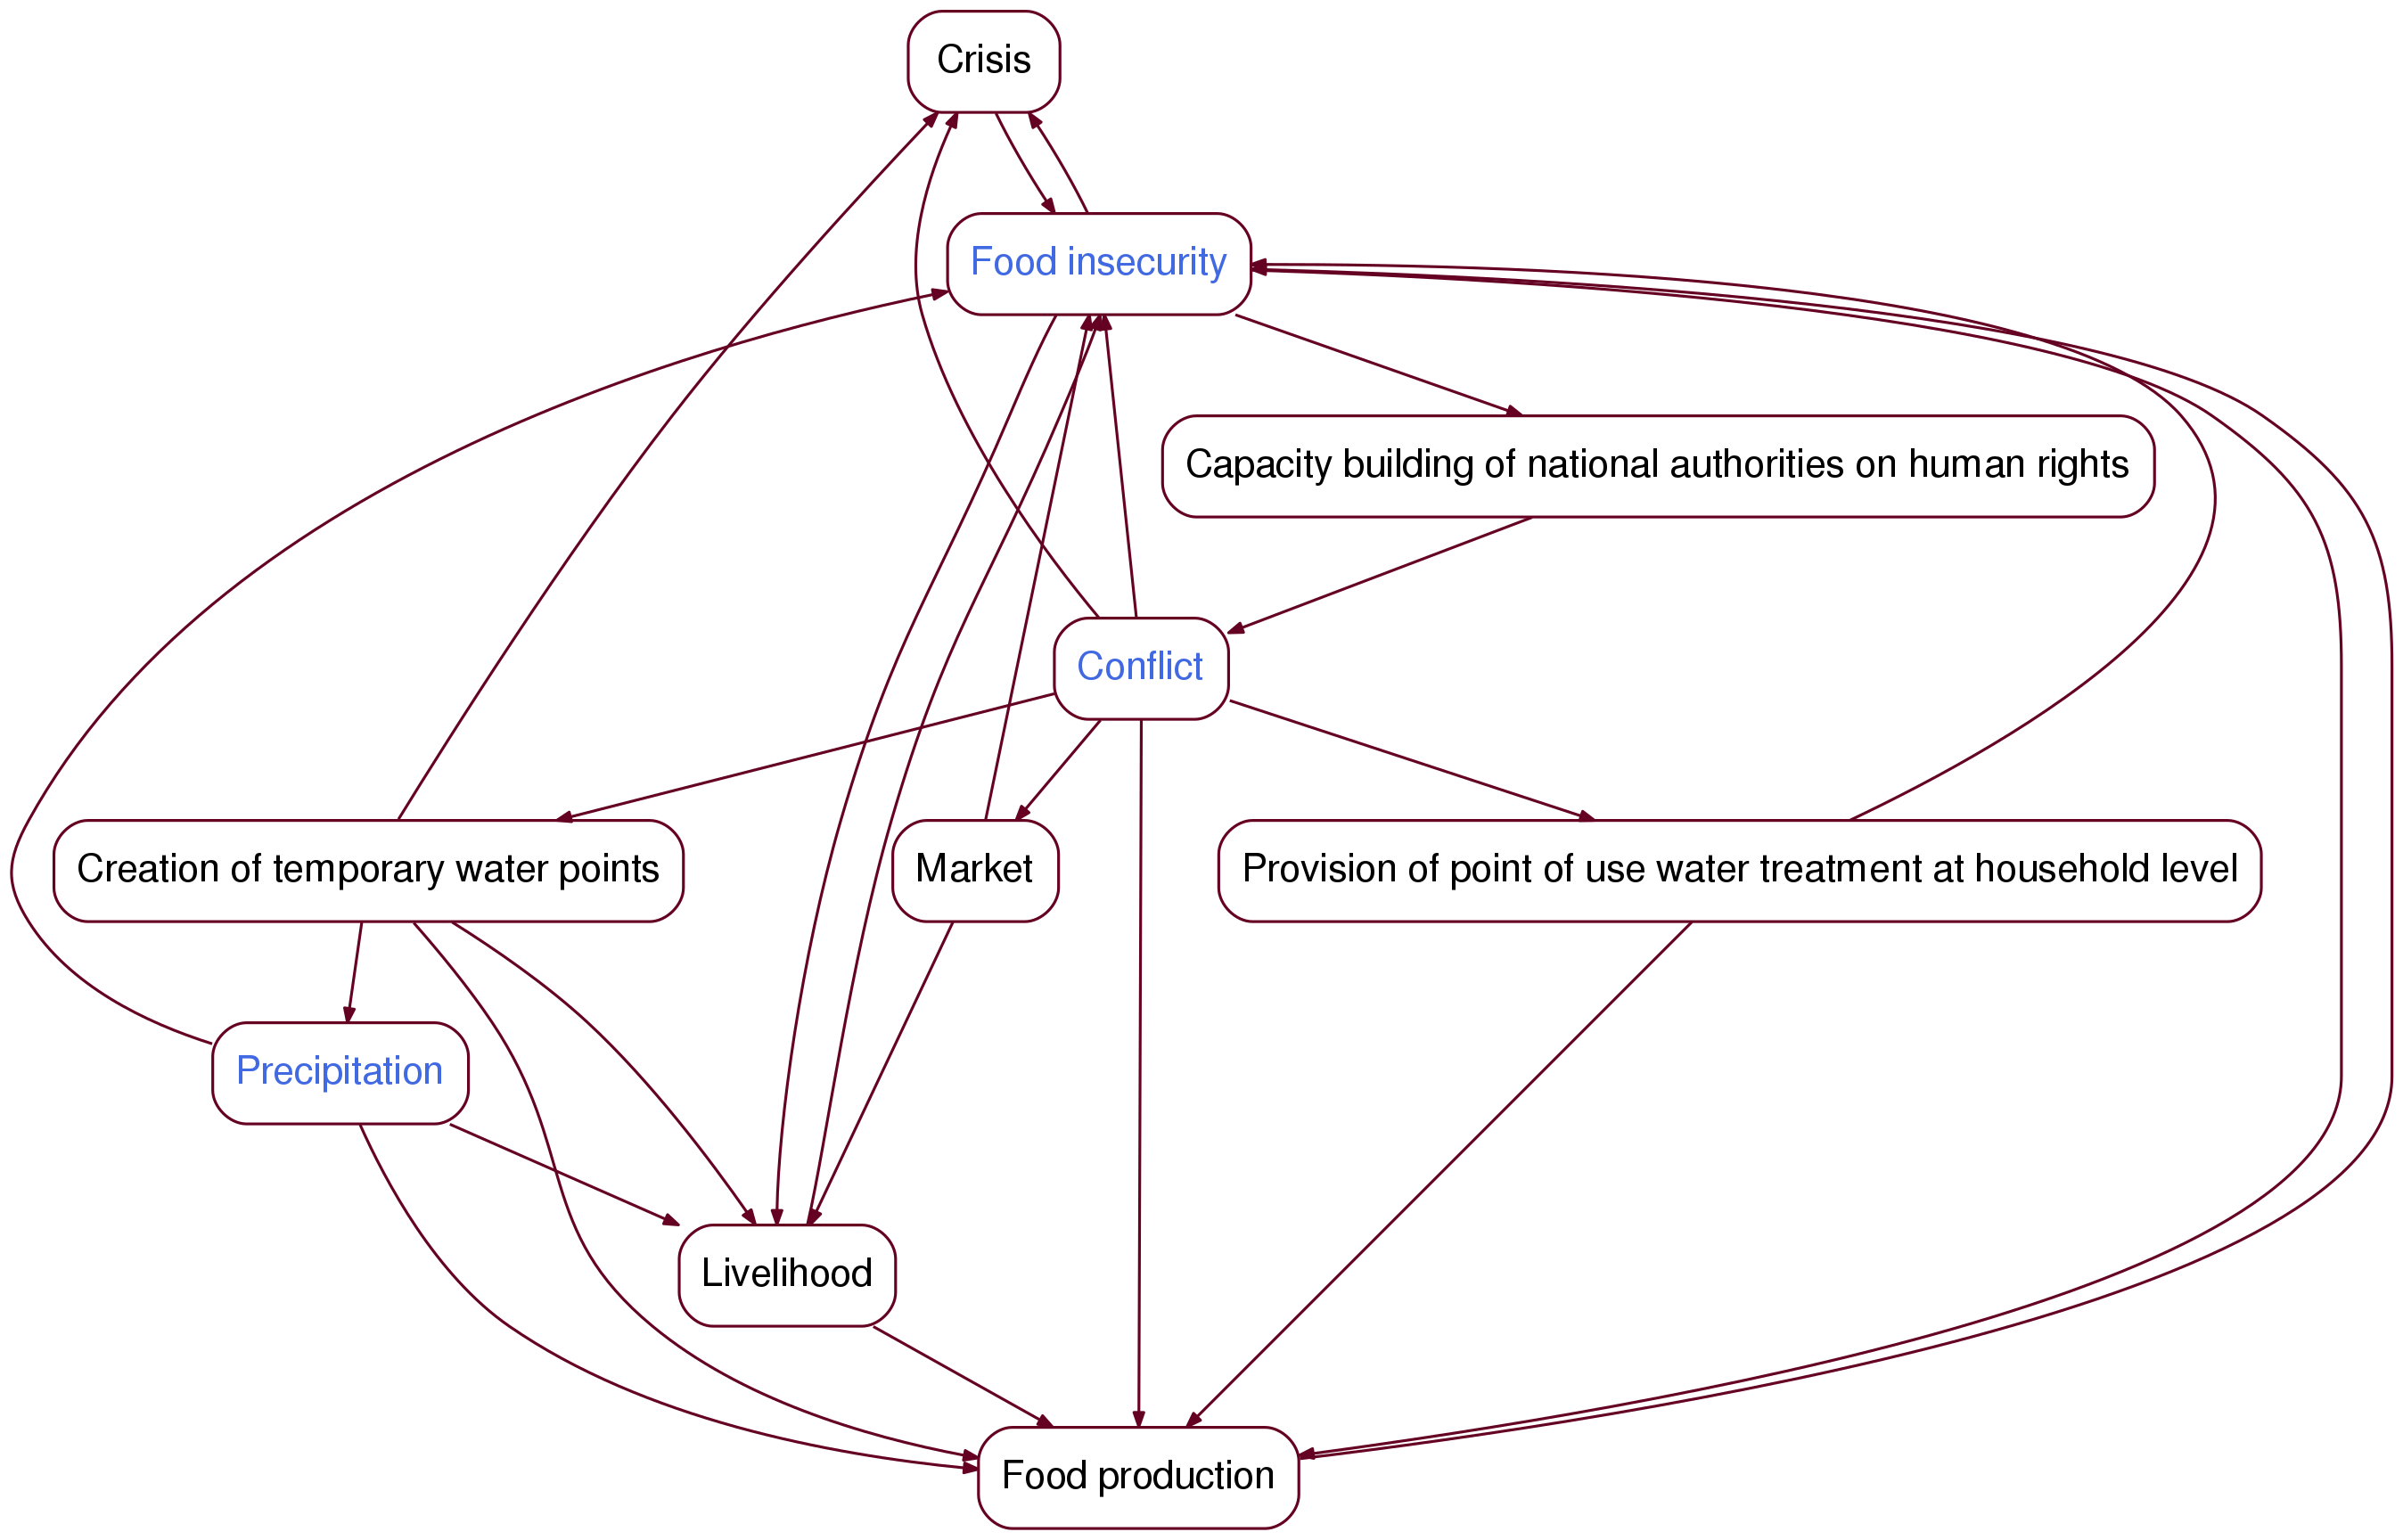

In [6]:
visualize(G, rankdir='TB', nodes_to_highlight=concepts)

## Inspecting and editing CAGs

## Inspecting statements

In [7]:
pd.options.display.max_colwidth=1000
pd.options.display.width=1000
jt.create_statement_inspection_table(statements(G))

## Removing incorrect edges

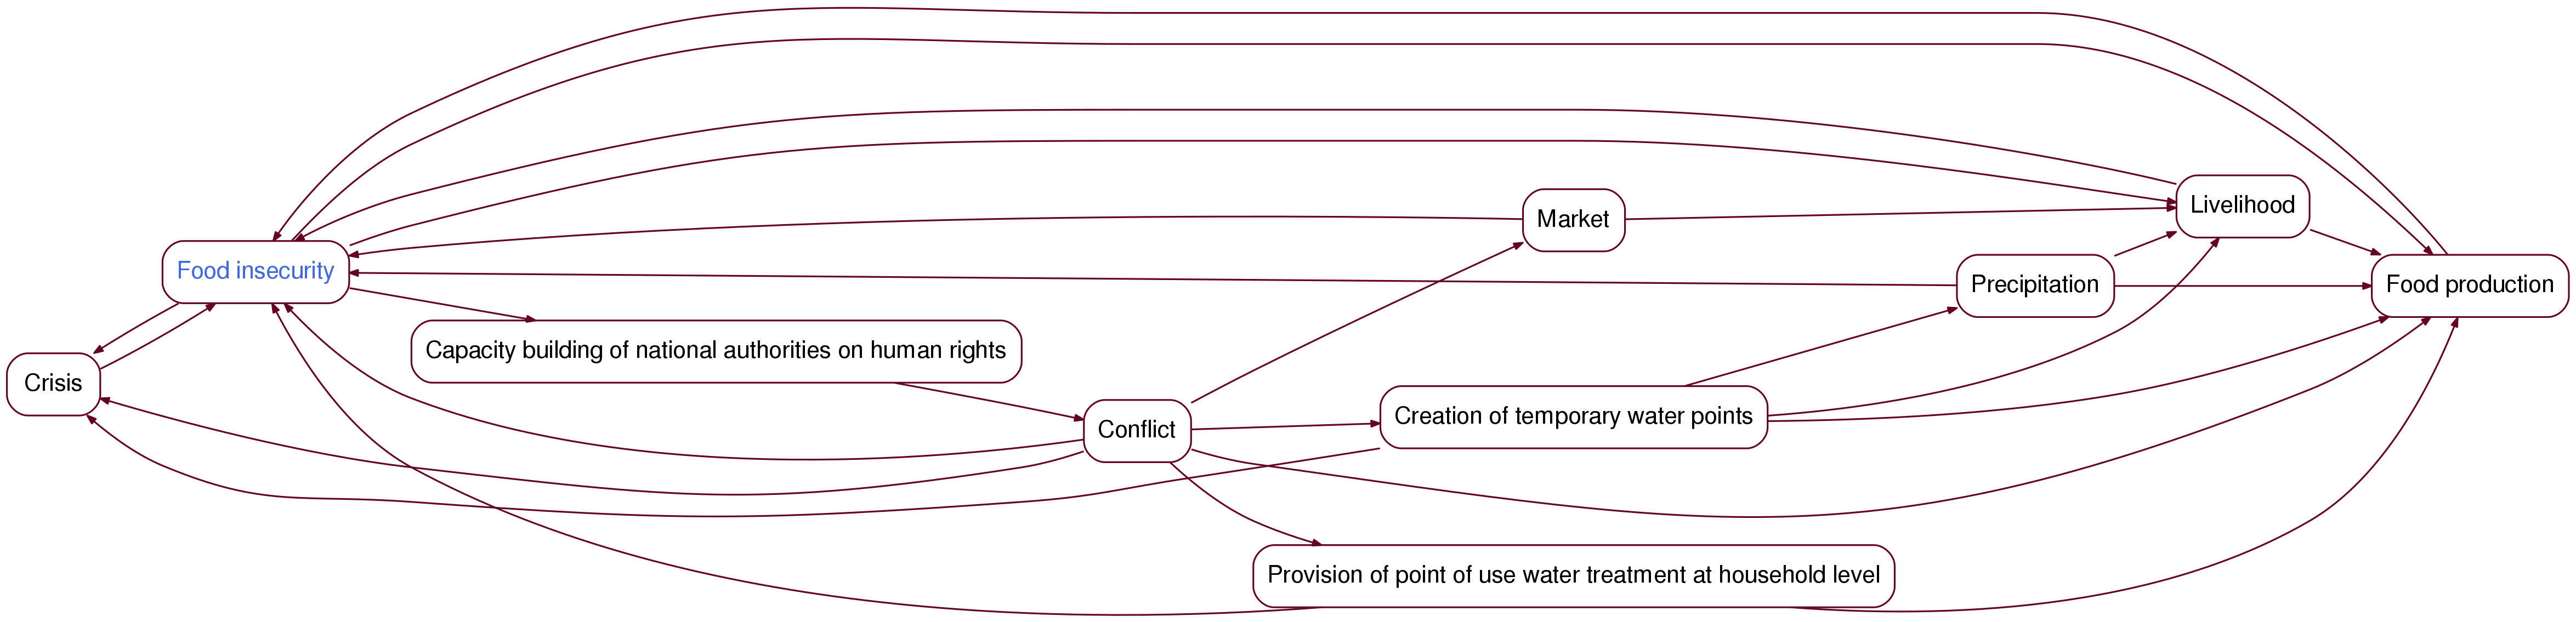

In [8]:
G.remove_edges_from([('food_insecurity', 'drought'), ('food_insecurity', 'food_insecurity')])
visualize(G, rankdir='LR', nodes_to_highlight='food_insecurity')

## Mapping concepts to indicators

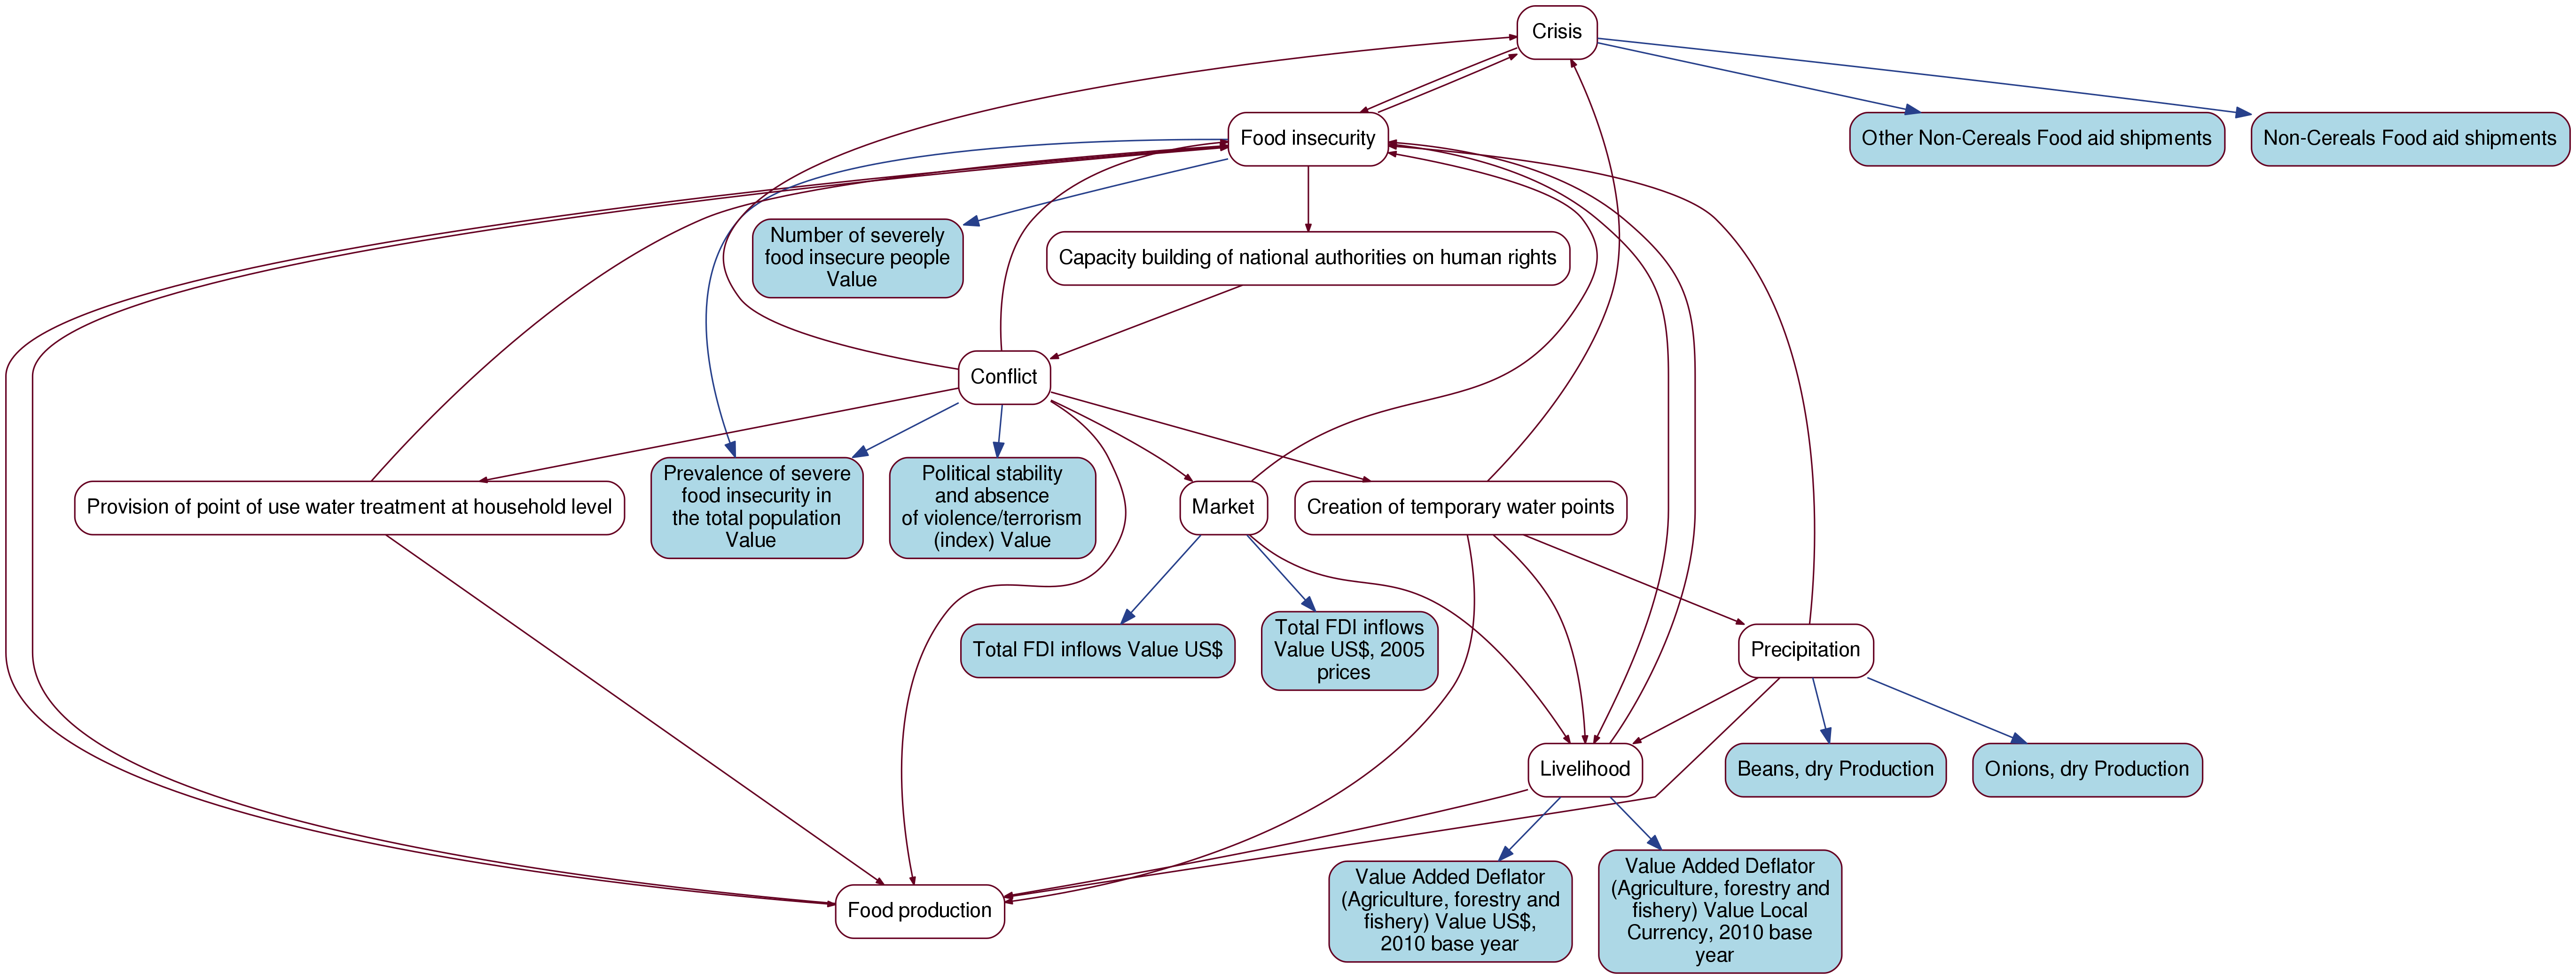

In [9]:
url = 'http://vision.cs.arizona.edu/adarsh/export/demos/data/concept_to_indicator_mapping.txt'
mapping = get_data_from_url(url)
map_concepts_to_indicators(G, 2, url)
visualize(G, indicators=True)

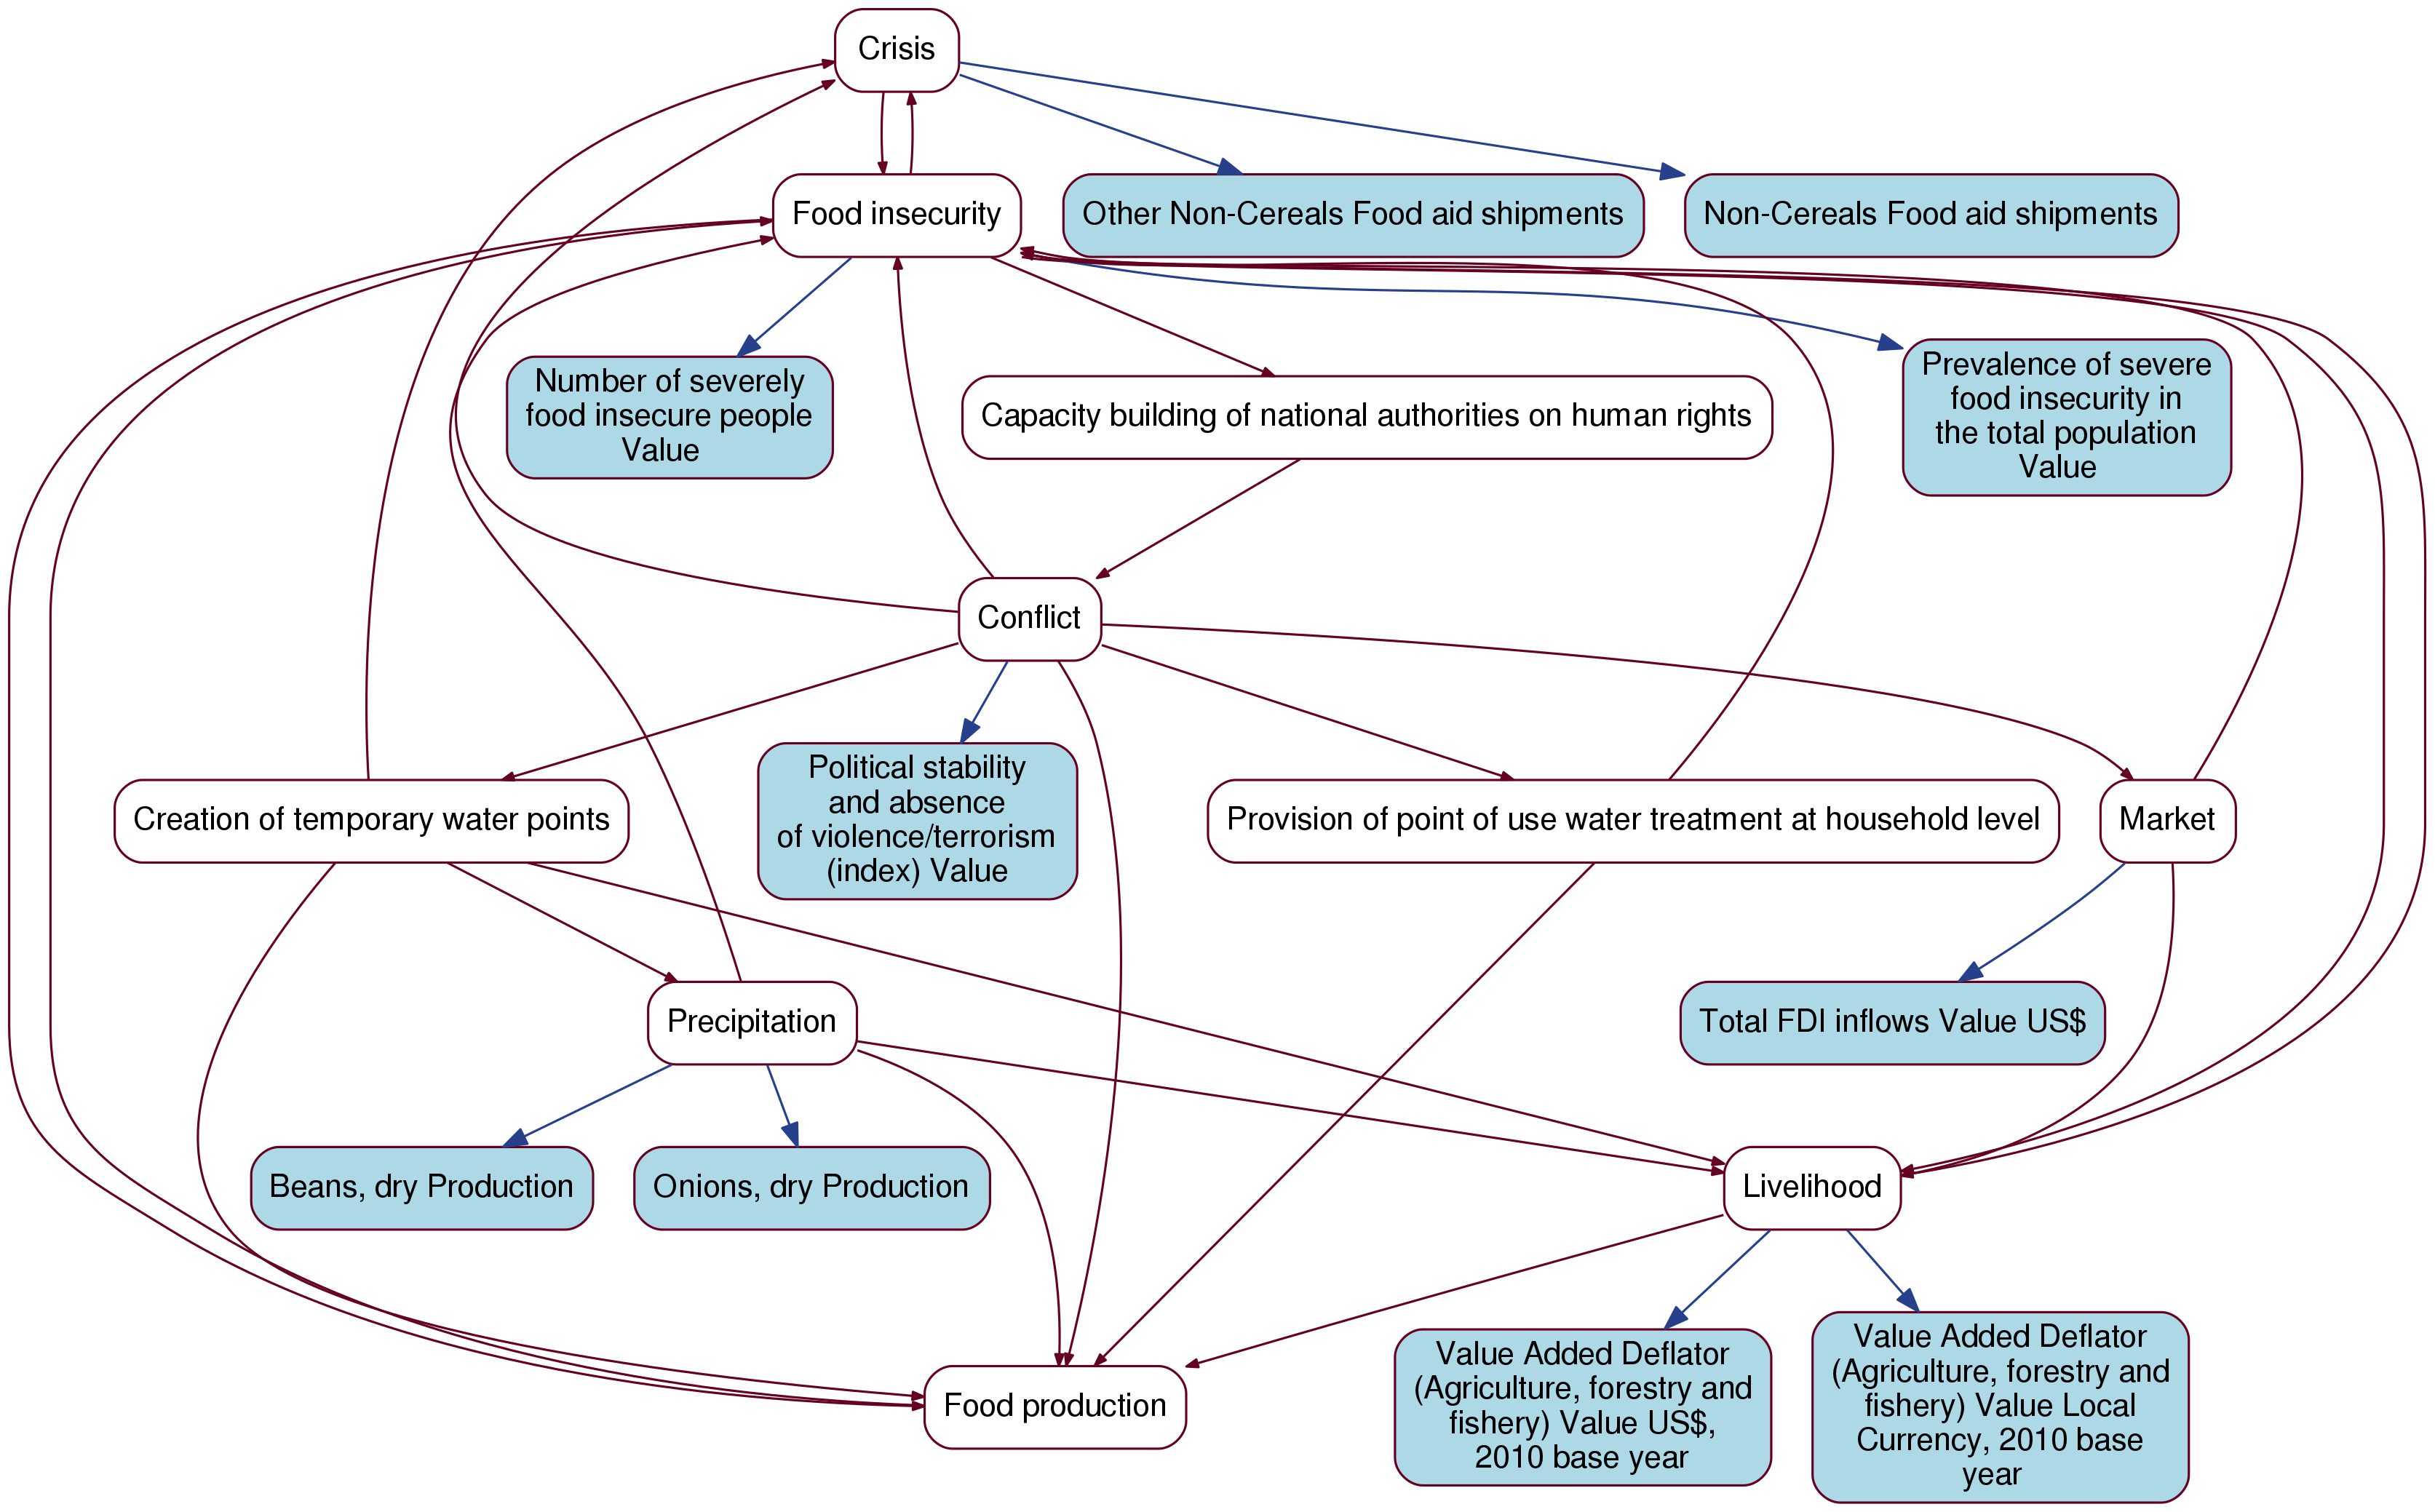

In [10]:
from delphi.random_variables import Indicator
G.nodes['conflict']['indicators'] = G.nodes['conflict']['indicators'][1:]
G.nodes['market']['indicators'] = G.nodes['market']['indicators'][1:]
visualize(G, indicators=True)

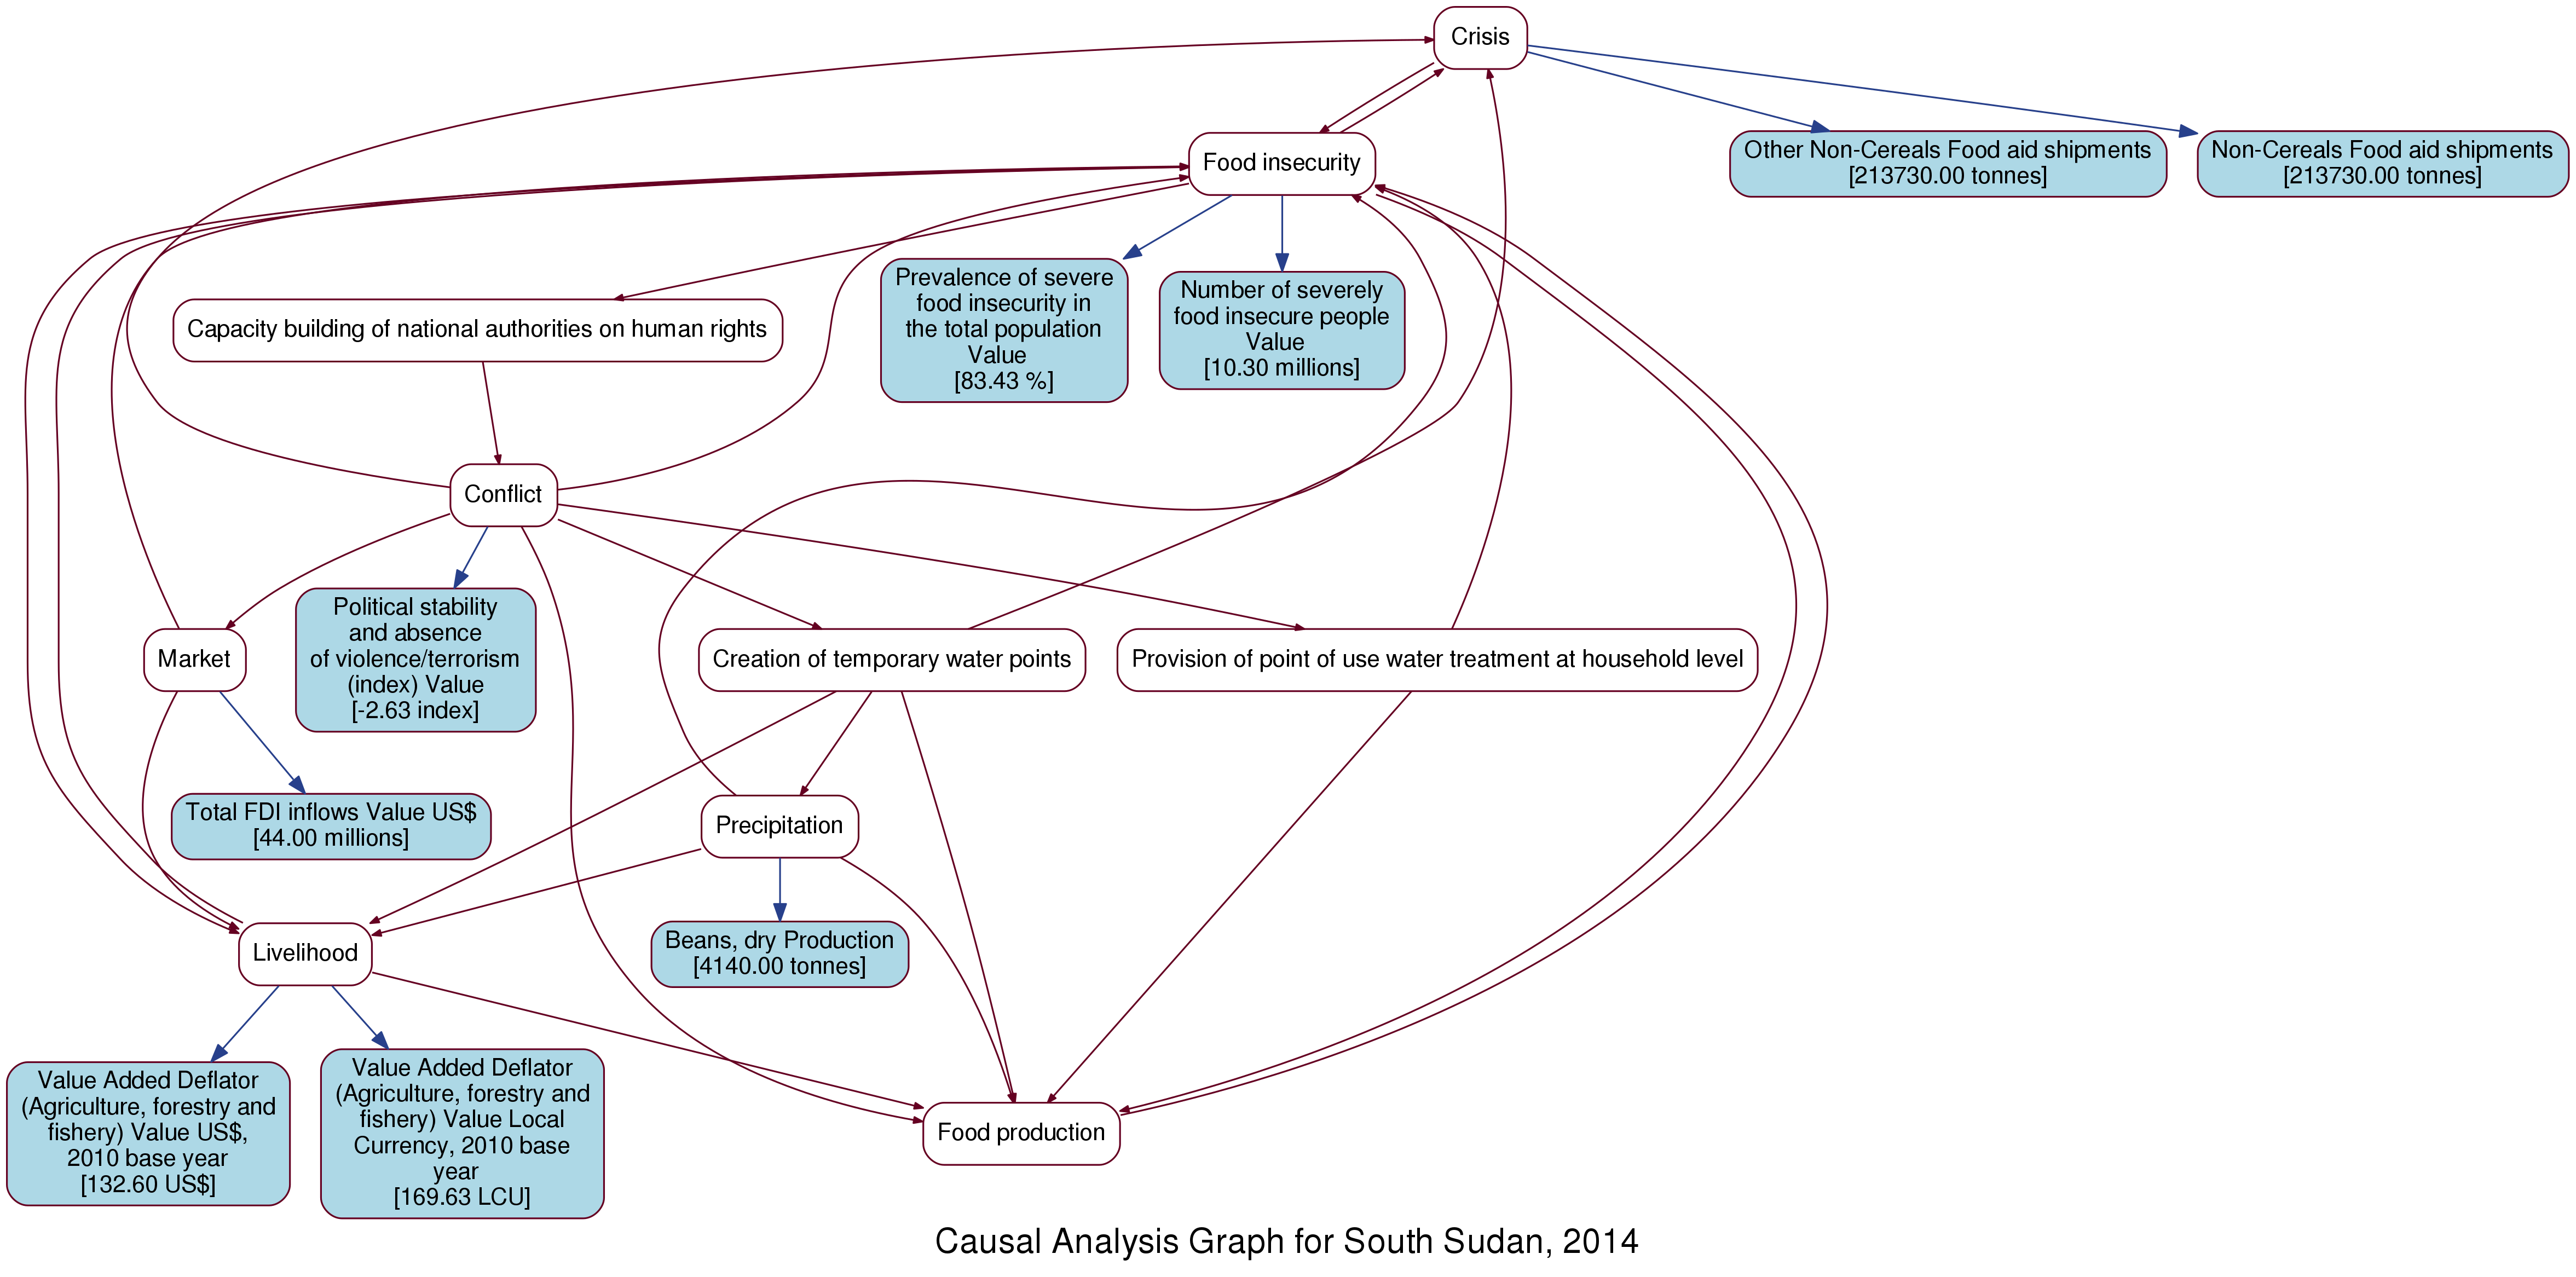

In [11]:
from datetime import datetime
from delphi.parameterization import parameterize
date = datetime(2014, 1, 1)
url = 'http://vision.cs.arizona.edu/adarsh/export/demos/data/south_sudan_data.csv'
df = pd.read_csv(url, sep="|", index_col="Indicator Name")
parameterize(G, datetime(2014, 1,1), df)
visualize(G, indicators=True, indicator_values = True,
          graph_label=f'Causal Analysis Graph for South Sudan, {date.year}')

## Infer transition model

In [12]:
url = 'http://vision.cs.arizona.edu/adarsh/export/demos/data/adjectiveData.tsv'
G.infer_transition_model(request.urlopen(url), 100)

## Set initial parameters

In [13]:
from delphi.export import export_default_initial_values
export_default_initial_values(G, variables_file='variables.csv')
s0 = pd.read_csv('variables.csv', index_col=0, header=None,
                 error_bad_lines=False)[1]
s0.loc['∂(conflict)/∂t'] = 0.1
s0.to_csv('variables.csv')
s0

0
crisis                                                                1.0
∂(crisis)/∂t                                                          0.0
creation of temporary water points                                    1.0
∂(creation of temporary water points)/∂t                              0.0
food_insecurity                                                       1.0
∂(food_insecurity)/∂t                                                 0.0
market                                                                1.0
∂(market)/∂t                                                          0.0
food_production                                                       1.0
∂(food_production)/∂t                                                 0.0
capacity building of national authorities on human rights             1.0
∂(capacity building of national authorities on human rights)/∂t       0.0
provision of point of use water treatment at household level          1.0
∂(provision of point of use water tr

## Execute model

/root/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


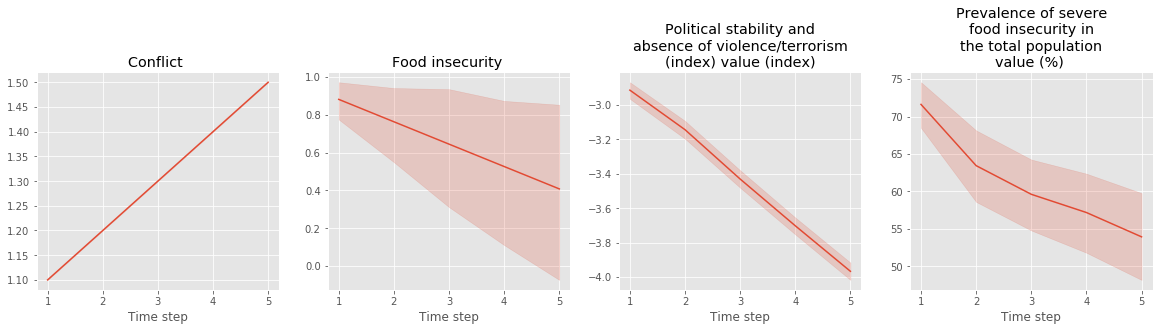

In [14]:
%matplotlib inline
from delphi.bmi import *
from matplotlib import pyplot as plt
import seaborn as sns
from delphi.utils.misc import _insert_line_breaks

initialize(G, 'variables.csv')
concept1 = 'conflict'
concept2 = 'food_insecurity'

ind1 = G.nodes[concept1]['indicators'][0]
ind2 = G.nodes[concept2]['indicators'][0]

plot_data = {variable: {'xs':[], 'ys':[],
                        'ylabel': variable.replace('_', ' ').capitalize(), 'units': '',
                       'ax_number': i} 
             for i, variable in enumerate((concept1, concept2, ind1.name, ind2.name))}

plot_data[ind1.name]['units'] = f"({ind1.unit})"
plot_data[ind2.name]['units'] = f"({ind2.unit})"

n_timesteps = 5
for day in range(n_timesteps):
    update(G)
    for concept in (concept1, concept2):
        for datapoint in G.nodes[concept]['rv'].dataset:
            plot_data[concept]['xs'].append(day+1)
            plot_data[concept]['ys'].append(datapoint)
        indicator = G.nodes[concept]['indicators'][0]
        for datapoint in indicator.dataset:
            if indicator.name != ind2.name:
                plot_data[indicator.name]['xs'].append(day+1)
                plot_data[indicator.name]['ys'].append(datapoint)
            else:
                if 0 < datapoint < 100:
                    plot_data[indicator.name]['xs'].append(day+1)
                    plot_data[indicator.name]['ys'].append(datapoint)
                    
        


fig, axes = plt.subplots(1,4, figsize=(20, 4))
for variable, plot_data in plot_data.items():
    ax = axes[plot_data['ax_number']]
    ax.set_xlabel('Time step')
    ax.set_xticks(range(6))
    ax.set_title(_insert_line_breaks(' '.join((plot_data['ylabel'], plot_data['units']))))
    sns.lineplot(plot_data['xs'], plot_data['ys'], ax = ax)

Still todo: truncate probability distributions from 0 to 100 for percentages.

In [15]:
from delphi.inspection import inspect_edge
inspect_edge(G, 'conflict', 'food_insecurity')

## Exploring the unknown unknowns

In [16]:
url = 'http://vision.cs.arizona.edu/adarsh/export/demos/data/pi_mtg_demo_unfiltered.pkl'
sts=pickle.load(get_data_from_url(url))

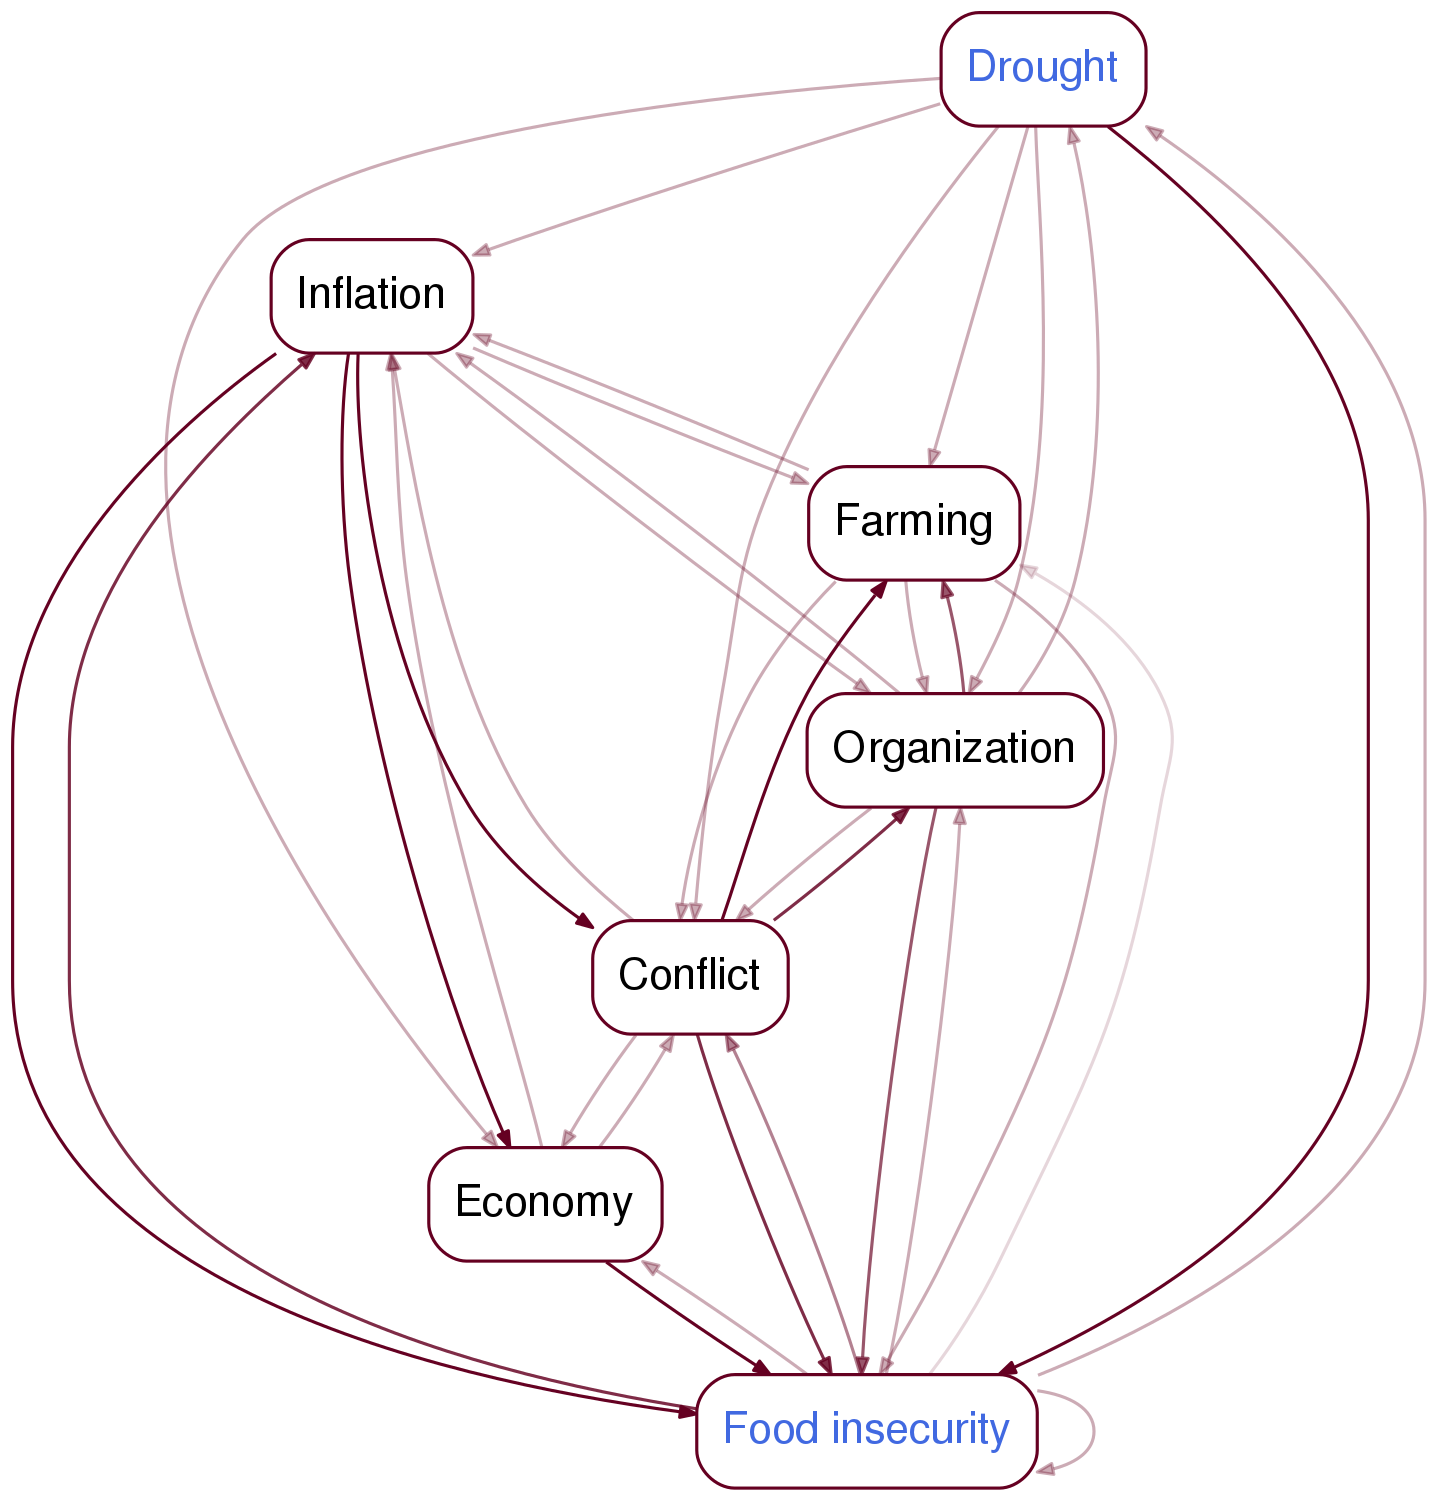

In [17]:
from delphi.subgraphs import get_subgraph_for_concept_pair
G = AnalysisGraph.from_statements(sts)
merge_nodes(G, 'food_security', 'food_insecurity', same_polarity=False)
G = get_subgraph_for_concept_pair(G, 'drought', 'food_insecurity', cutoff=2)
visualize(G, nodes_to_highlight=['drought','food_insecurity'])